# NWA suntans: monthly averaged statistics


In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

from oceans.filters import lanc

import pynsitu as pin
crs = pin.maps.crs

import nwatools as nwa

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datahome/aponte/.miniconda3/envs/equinox/share/proj failed


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(cores=28, processes=14)
    #cluster = PBSCluster(cores=14, processes=7)
    w = cluster.scale(jobs=2)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

---
## load data

In [32]:
ds, grd = nwa.load_surf()

In [33]:
# add deformations
zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_gradients")
dsd = xr.open_zarr(zarr)

dsd["vorticity"] = dsd["dvcdx"] - dsd["ducdy"]
dsd["divergence"] = dsd["ducdx"] + dsd["dvcdy"]
dsd["strain_normal"] = dsd["ducdx"] - dsd["dvcdy"]
dsd["strain_shear"] = dsd["dvcdx"] + dsd["ducdy"]

In [35]:
ds = xr.merge([ds, dsd]).persist()

## compute monthly statistics

In [36]:
ds_mean = ds.resample(time='1MS').mean().chunk(dict(time=-1)).persist()

In [37]:
zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_monthly_mean")
ds_mean.to_zarr(zarr, mode="w")

In [39]:
ds_std = ds.resample(time='1MS').std().chunk(dict(time=-1)).persist()

In [43]:
zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_monthly_std")
ds_std.to_zarr(zarr, mode="w")

## reload and make some plots

In [ ]:
zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_monthly_mean")
ds_mean = xr.open_zarr(zarr)

zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_monthly_std")
ds_std = xr.open_zarr(zarr)

In [53]:
area = nwa.area_cp
_ds = nwa.zoom(ds_std, area).mean("Nc").isel(time=slice(0,-1))

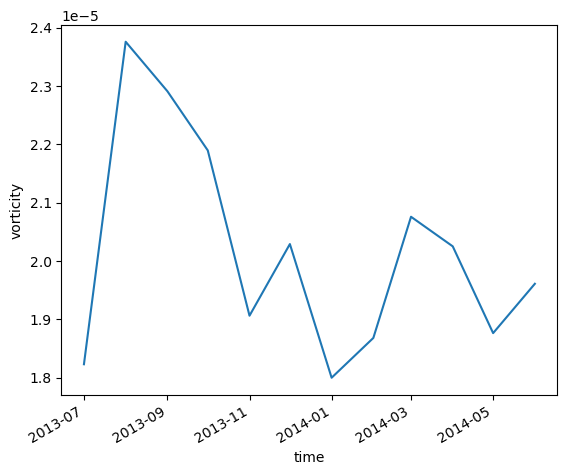

In [54]:
_ds["vorticity"].plot()

---

In [55]:
cluster.close()